<a href="https://colab.research.google.com/github/fares-mldev/uns-pdi2021/blob/main/tp8/PDI_TP8_Resampling_Quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TP8: Resampling y Cuantización

Implementar un aplicativo que permita abrir una imagen y con esta obtener:

- Downsampling X2 (mostrando la imagen resultado al doble de tamaño para comparar el efecto) utilizando kernel constante, bilineal, y bicúbico.

- Upsampling X2 (mostrando la imagen original al doble de tamaño para comparar el efecto) utilizando kernel constante, bilineal, y bicúbico.

- Cuantización a cantidad de niveles de gris variable, utilizando uniforme, dithering aleatorio, y difusión del error por scan-line.

**Nota**: Todas las funciones de Downsamplig, Upsampling y Cuantización deben ser desarrolladas como funciones propias y NO con funciones de biblioteca. 


In [13]:
#@title Imports

# Import numpy
import numpy as np

# Import imageio
import imageio as iio

# Import matplotlib
import matplotlib.pyplot as plt

# Import widgets
import ipywidgets as widgets
from IPython.display import display

# Install and import wget
!pip install wget
import wget


In [14]:
#@title Image utils

# Images URL list 
# https://testimages.org/sampling_patterns/

url_dict = {}
url_dict["bacteria"] = "https://github.com/fares-mldev/uns-pdi2021/raw/main/tp5/img/bacteria.jpg"
url_dict["head"] = "https://github.com/fares-mldev/uns-pdi2021/raw/main/tp5/img/head.jpg"
url_dict["retina"] = "https://github.com/fares-mldev/uns-pdi2021/raw/main/tp5/img/retina.jpg"
url_dict["mnist"] = "https://raw.githubusercontent.com/fares-mldev/uns-pdi2021/main/tp8/img/mnist_lo.png"

def get_image(image: str, fn="") -> np.array:
    '''
    Downloads specified image from the web and returns it as a numpy array
    '''
    # Read image from file
    img = iio.imread(url_dict[image]+fn)

    # Return image
    return np.asarray(img[:,:,:3])

# RGB to YIQ space transformation matrix
rgb_to_yiq = [[0.299, 0.587, 0.114],
              [0.595716, -0.274453, -0.321263],
              [0.211456, -0.522591, 0.311135]]

# YIQ to RGB space transformation matrix
yiq_to_rgb = [[1, 0.9663, 0.6210],
              [1, -0.2721, -0.6474],
              [1, -1.1070, 1.7046]]

def plot_img(img: np.array, ax = None):
  '''
  Plots image using matplotlib 
  '''

  # If no axis sprecified get handle
  if ax is None:
    ax = plt.gca()

  # Show image
  ax.imshow(img)

def describe_img(img: np.array):
  '''
  Prints image properties
  '''
  print("Image shape (height,width,channels):", img.shape)
  print("Element type:", img.dtype)
  print("Total number of pixels:",img.size)
  print("Pixels per channel:", int(img.size/img.shape[2]))
  print("min-max value of channel 0:",img[:,:,0].min(),img[:,:,0].max())
  print("min-max value of channel 1:",img[:,:,1].min(),img[:,:,1].max())
  print("min-max value of channel 2:",img[:,:,2].min(),img[:,:,2].max())
  
def convert_rgb2yiq(img_rgb: np.array) -> np.array:
  '''
  Converts an RGB image to YIQ space
  '''
  
  # Normalize image
  img_rgb_n = img_rgb.astype(np.float64) / 255.0  
  
  # Apply transformation
  img_yiq = np.dot(img_rgb_n,rgb_to_yiq)
  
  # Clip to limits

  # Return YIQ image
  return img_yiq

def convert_yiq2rgb(img_yiq: np.array) -> np.array:
  '''
  Converts an YIQ image to RGB space
  '''

  # Apply transformation
  img_rgb_n= np.dot(img_yiq,yiq_to_rgb)
  
  # Clip image 
  img_rgb = img_rgb_n.clip(0,1) * 255.0
  
  # Return RGB image
  return img_rgb.astype(np.uint8) 

def get_y(im):
  '''
  Gets the luminance (Y) channel of an image
  '''
  return convert_rgb2yiq(im)[:,:,0]

def get_fft(im):
  '''
  Gets the magnitude and phase channels on an image
  '''
  fc = np.fft.fftshift(np.fft.fft2(im))

  mag = np.abs(fc)
  phase = np.angle(fc)

  return mag,phase

def get_ifft(fft_img):
    
  # reverse the 2D fourier transform
  img = np.fft.ifft2(np.fft.ifftshift(fft_img))
  img = np.abs(img)

  return img

def polar_to_rect(mag, phase):
  '''
  Recovers complex from magnitude and phase  
  '''
  return mag * np.exp(1j*phase)

def plot_fft(im, desc= '', type = 'log'):
  '''
  Plots an image, together with its fft magnitude and phase
  '''
  fig, axes = plt.subplots(1,3)
  fig.set_size_inches(21,7)
  mag, phase = get_fft(im)

  axes[0].imshow(im, cmap = 'gray')
  axes[0].set_title(desc)
  if type == 'log':
    axes[1].imshow(np.log(mag), cmap = 'gray')
  if type == 'sqrt':
    axes[1].imshow(np.power(mag,0.2), cmap = 'gray')
  
  axes[1].set_title('fft magnitude')
  axes[2].imshow(phase, cmap = 'gray')
  axes[2].set_title('fft phase')
  
def save_img(fn: str, im: np.array):
  '''
  Saves a image to disk
  '''
  # Clip and scale image 
  im = im.clip(0,1) * 255.0
  im = im.astype(np.uint8) 

  # Write to file
  iio.imwrite(fn,im)

def save_fig(fn):
  # Write results to file
  fig = plt.gcf()
  fig.savefig(fn)

def norm_img(im):
  '''
  Normalize image between 0 and 255.0
  '''
  return (im - np.min(im)) / (np.max(im) - np.min(im)) * 255.0

def plot_fft_mag(im, desc= '', type = 'log'):
  '''
  Plots an image, together with its fft magnitude 
  '''
  fig, axes = plt.subplots(1,2)
  fig.set_size_inches(10,5)
  mag, phase = get_fft(im)

  axes[0].imshow(im, cmap = 'gray')
  axes[0].set_title(desc)
  if type == 'log':
    axes[1].imshow(np.log(mag), cmap = 'gray')
  if type == 'sqrt':
    axes[1].imshow(np.power(mag,0.2), cmap = 'gray')
  
  axes[1].set_title('fft magnitude')

def save_img(fn: str, im: np.array):
  '''
  Saves a image to disk
  '''
  # Clip and scale image 
  im = im.clip(0,1) * 255.0
  im = im.astype(np.uint8) 

  # Write to file
  iio.imwrite(fn,im)

def save_fig(fn):
  # Write results to file
  fig = plt.gcf()
  fig.savefig(fn)

def plot_compare(im_orig,im_filt,name,operation):
  # Create figure
  fig, axes = plt.subplots(1,2)
  fig.set_size_inches(16,8)

  axes[0].imshow(im_orig, cmap = 'gray')
  axes[0].set_title(name + ' - original')

  axes[1].imshow(im_filt, cmap = 'gray')
  axes[1].set_title(name + ' - ' + operation)

In [87]:
#@title Subsample utils

def conv_2d(im, kernel, pad = 0, stride = 1):
  '''
  Perform convolution between an image and a 2d kernel
  '''

  # Prescale image
  im = im.copy() / im.max()

  # Get image shape
  im_h = im.shape[0] 
  im_w = im.shape[1] 

  # Get kernel shape
  k_h = kernel.shape[0]
  k_w = kernel.shape[1]

  # Create output image
  out = np.zeros(((im.shape[0]+pad)//stride,(im.shape[1]+pad)//stride)) 

  # Loop over rows
  for row in range(0,im_h,stride):

    # Loop over cols
    for col in range(0,im_w,stride):

      # Get sub image index ranges 
      range_w = range((col - pad), (col - pad + k_w ))
      range_h = range((row - pad), (row - pad + k_h ))

      # Clip to real indexes
      idx_w = np.clip(np.array(range_w),0,im_w-1)
      idx_h = np.clip(np.array(range_h),0,im_h-1)

      # Slice image
      sub_im = im[np.ix_(idx_h,idx_w)]
      
      # Apply kernel
      out[row//stride,col//stride] = np.multiply(sub_im,kernel).sum()

  return out
  
def downx2_flat(im):
  '''
  Perform x2 downsampling with flat kernel 
  '''
  kernel = np.array([[1,0],[0,0]])
  out = conv_2d(im,kernel,pad = 0, stride = 2)

  return out

def downx2_bilinear(im):
  '''
  Perform x2 downsampling with bilinear kernel 
  '''
  kernel = np.array([[1,1],[1,1]])/4
  out = conv_2d(im,kernel,pad = 0, stride = 2)

  return out

def W(x,a=-1):
  '''
  Bicubic kernel function for convolution
  '''

  if np.abs(x) <= 1:
    return (a+2)*np.abs(x)**3 - (a+3) * np.abs(x)**2 + 1

  if (np.abs(x) > 1) and (np.abs(x) <= 2):
    return a * np.abs(x)**3- 5 * a * np.abs(x)**2 + 8 * a * np.abs(x) - 4 * a
  
  return np.NaN

def cubic_kernel(X):
  '''
  F : 1x4 matrix containing kernel evaluated in elements of X 
  '''
  return np.array([W(x) for x in X])

def bicubic_kernel(X):
  '''
  F : 1x4 matrix containing kernel evaluated in elements of X 
  '''
  return np.outer(cubic_kernel(X),cubic_kernel(X))

def downx2_bicubic(im):
  '''
  Perform x2 downsampling with bicubic kernel 
  '''

  k2d = bicubic_kernel([-3/2,-1/2,1/2,-3/2])

  out = conv_2d(im,k2d, pad = 1, stride = 2)

  return out


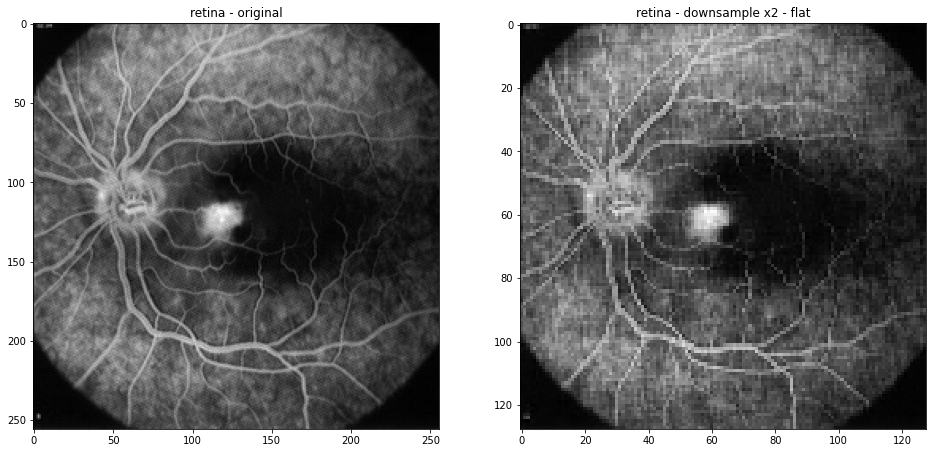

In [104]:
#@title Subsample x2 flat { run: "auto" }

image = "retina" #@param ["retina","bacteria","head","mnist"]

# Get image

im = get_y(get_image(image))

im_sub = downx2_flat(im)

# Plot result
plot_compare(im,im_sub,image,'downsample x2 - flat')

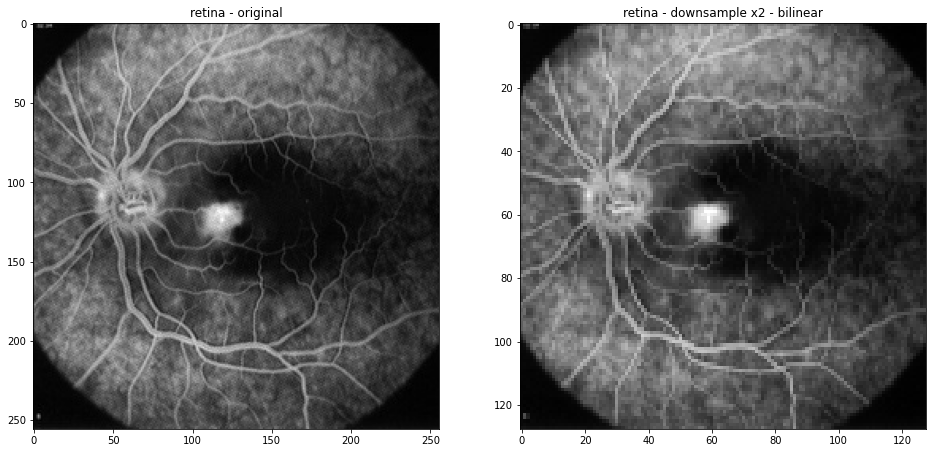

In [105]:
#@title Subsample x2 bilinear{ run: "auto" }

image = "retina" #@param ["retina","bacteria","head","mnist"]

# Get image
im = get_y(get_image(image))

im_sub = downx2_bilinear(im)

# Plot result
plot_compare(im,im_sub,image,'downsample x2 - bilinear')

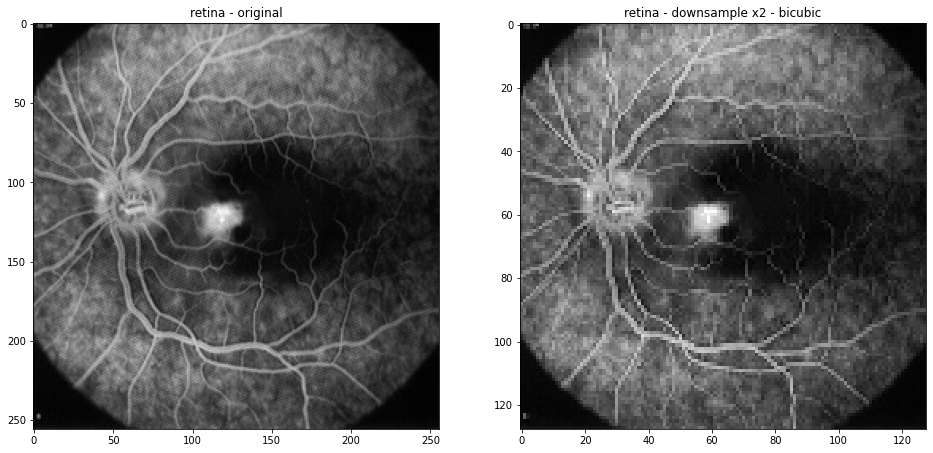

In [106]:
#@title Subsample x2 bicubic { run: "auto" }

image = "retina" #@param ["retina","bacteria","head","mnist"]

# Get image
im = get_y(get_image(image))

im_sub = downx2_bicubic(im)

# Plot result
plot_compare(im,im_sub,image,'downsample x2 - bicubic')

Text(0.5, 1.0, 'bicubic')

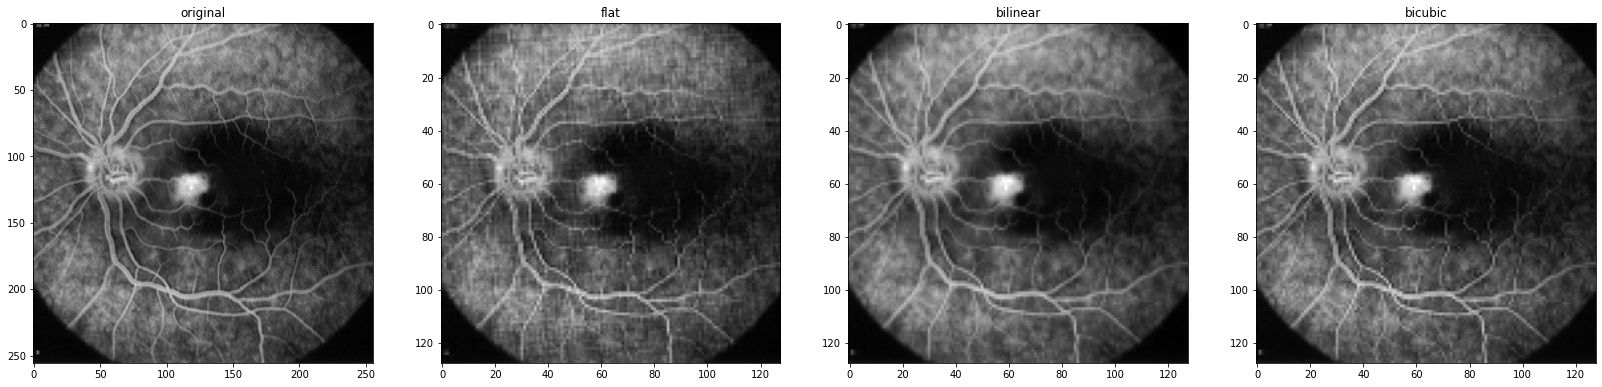

In [107]:
#@title Subsample x2 comparison { run: "auto" }

image = "retina" #@param ["retina","bacteria","head","mnist"]

# Get image
im = get_y(get_image(image))

# Compute subsampling
im_flat = downx2_flat(im)
im_bilinear = downx2_bilinear(im)
im_bicubic = downx2_bicubic(im)

# Plot result
fig, axs = plt.subplots(1,4)
fig.set_size_inches(28,7)

axs[0].imshow(im,cmap = 'gray')
axs[0].set_title('original')

axs[1].imshow(im_flat,cmap = 'gray')
axs[1].set_title('flat')

axs[2].imshow(im_bilinear,cmap = 'gray')
axs[2].set_title('bilinear')

axs[3].imshow(im_bicubic,cmap = 'gray')
axs[3].set_title('bicubic')

In [92]:
#@title Upsample utils

def upx2_flat(im):

  '''
  Perform x2 sample and hold upsampling
  '''

  # Prescale image
  im = im.copy() / im.max()

  # Get output image shape
  im_h = im.shape[0] * 2
  im_w = im.shape[1] * 2

  # Create output image
  out = np.zeros((im_h, im_w)) 

  # Loop over rows
  for row in range(im_h):

    # Loop over cols
    for col in range(im_w):
      
      # Apply kernel
      out[row,col] = im[row//2,col//2]

  return out

def bilinear(F,x,y):
  '''
  https://en.wikipedia.org/wiki/Bilinear_interpolation

  Returns the bilinear interpolation f(x,y)
  f(x,y) = [1-x x] * F * [1-y y]'

  F : 2x2 matrix containing known values of f(x,y) F = [ [ f(0,0), f(0,1) ], [ f(1,0), f(1,1) ] ]
  '''

  out = np.array([1-x, x]).reshape(1,-1) @ F @ np.array([1-y, y]).reshape(-1,1)  

  return np.float64(out)

def upx2_bilinear(im):

  '''
  Perform x2 bilinear upsampling
  '''

  # Prescale image
  im = im.copy() / im.max()

  # Get output image shape
  im_h = im.shape[0]
  im_w = im.shape[1]

  # Create output image
  out = np.zeros((im_h * 2, im_w * 2)) 

  # Loop over rows
  for row in range(im_h):

    # Loop over cols
    for col in range(im_w):
      
      # Get sub image index ranges 
      range_w = range(col, col + 2)
      range_h = range(row, row + 2)

      # Clip to real indexes
      idx_w = np.clip(np.array(range_w),0,im_w-1)
      idx_h = np.clip(np.array(range_h),0,im_h-1)

      # Slice image
      F = im[np.ix_(idx_h,idx_w)]

      # Apply bilinear interpolation
      out[2*row,2*col] = bilinear(F,0,0)
      out[2*row,2*col+1] = bilinear(F,0,0.5)
      out[2*row+1,2*col] = bilinear(F,0.5,0)
      out[2*row+1,2*col+1] = bilinear(F,0.5,0.5)

  return out



def upx2_bicubic(im):

  '''
  Perform x2 bilinear upsampling
  '''

  # Prescale image
  im = im.copy() / im.max()

  # Get output image shape
  im_h = im.shape[0]
  im_w = im.shape[1]

  # Create output image
  out = np.zeros((im_h * 2, im_w * 2)) 

  k1d = cubic_kernel(np.array([-3/2,-1/2,1/2,-3/2]))
  k2d = bicubic_kernel(np.array([-3/2,-1/2,1/2,-3/2]))
      
  # Loop over rows
  for row in range(im_h):

    # Loop over cols
    for col in range(im_w):
      
      # Get sub image index ranges 
      range_w = range(col-1, col + 3)
      range_h = range(row-1, row + 3)

      # Clip to real indexes
      idx_w = np.clip(np.array(range_w),0,im_w-1)
      idx_h = np.clip(np.array(range_h),0,im_h-1)

      # Slice image
      F_row = im[np.ix_([row],idx_w)]
      F_col = im[np.ix_(idx_h,[col])]
      F = im[np.ix_(idx_h,idx_w)]

      # Apply bicubic interpolation
      out[2*row,2*col] = im[row,col]
      out[2*row,2*col+1] = F_row @ k1d
      out[2*row+1,2*col] = k1d @ F_col
      out[2*row+1,2*col+1] = np.multiply(F,k2d).sum()

  return out


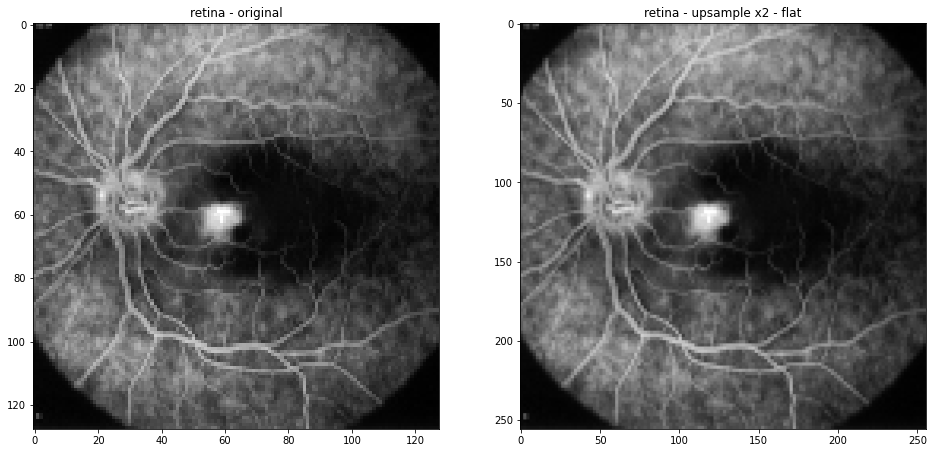

In [108]:
#@title Upsample x2 flat (zero-hold) { run: "auto" }

image = "retina" #@param ["retina","bacteria","head","mnist"]

# Get image
im = get_y(get_image(image))
im_sub = downx2_bilinear(im)
im_up = upx2_flat(im_sub)

# Plot result
plot_compare(im_sub,im_up,image,'upsample x2 - flat')

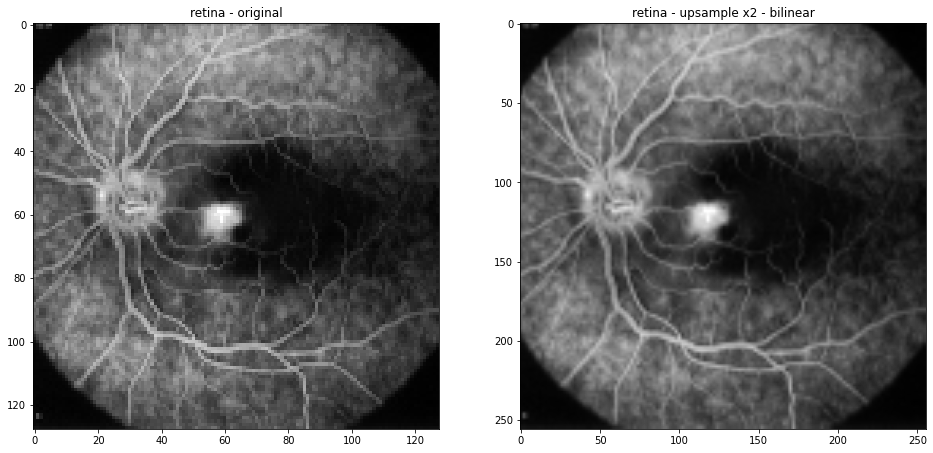

In [109]:
#@title Upsample x2 bilinear { run: "auto" }

image = "retina" #@param ["retina","bacteria","head","mnist"]

# Get image
im = get_y(get_image(image))
im_sub = downx2_bilinear(im)
im_up = upx2_bilinear(im_sub)

# Plot result
plot_compare(im_sub,im_up,image,'upsample x2 - bilinear')

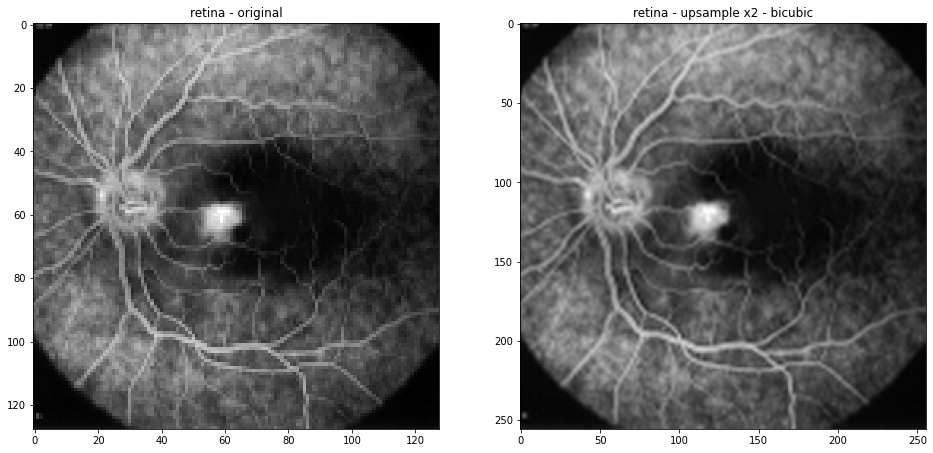

In [110]:
#@title Upsample x2 bicubic { run: "auto" }

image = "retina" #@param ["retina","bacteria","head","mnist"]

# Get image
im = get_y(get_image(image))
im_sub = downx2_bilinear(im)
im_up = upx2_bicubic(im_sub)

# Plot result
plot_compare(im_sub,im_up,image,'upsample x2 - bicubic')

Text(0.5, 1.0, 'bicubic')

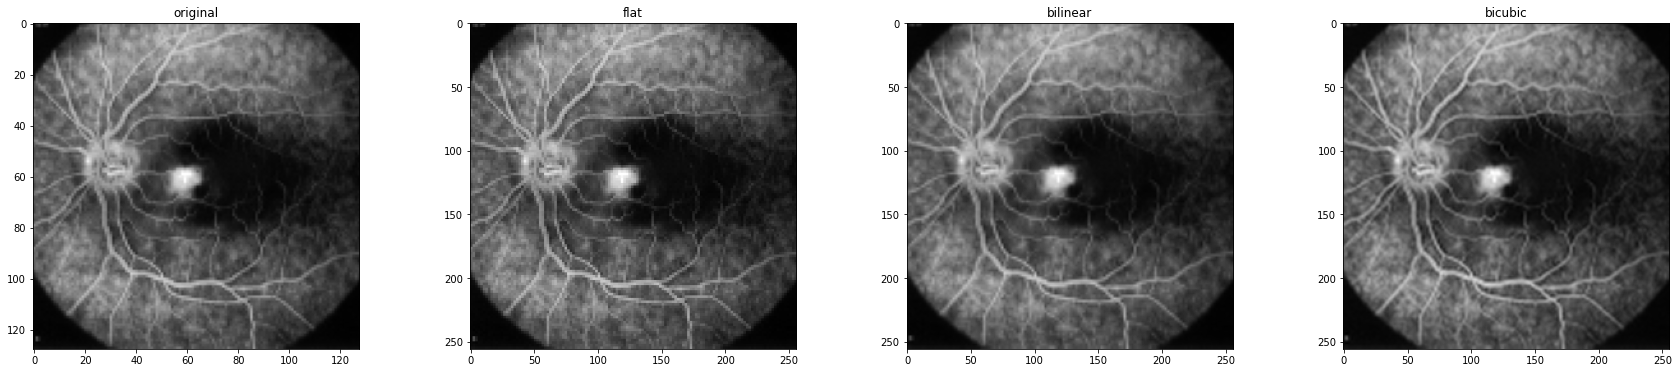

In [98]:
#@title Upsample x2 comparison { run: "auto" }

image = "retina" #@param ["retina","bacteria","head","mnist"]

# Get image
im = get_y(get_image(image))
im = downx2_bilinear(im)

# Compute subsampling
im_flat = upx2_flat(im)
im_bilinear = upx2_bilinear(im)
im_bicubic = upx2_bicubic(im)

# Plot result
fig, axs = plt.subplots(1,4)
fig.set_size_inches(30,6)

axs[0].imshow(im,cmap = 'gray')
axs[0].set_title('original')

axs[1].imshow(im_flat,cmap = 'gray')
axs[1].set_title('flat')

axs[2].imshow(im_bilinear,cmap = 'gray')
axs[2].set_title('bilinear')

axs[3].imshow(im_bicubic,cmap = 'gray')
axs[3].set_title('bicubic')

In [27]:
#@title Quantization utils

def quant_uniform(im, n):
  '''
  Performs uniform quantization of n levels
  '''

  # Prescale image
  im = im.copy() / im.max()

  return np.round(im * (n-1)) 

def quant_dither_random(im, n):
  '''
  Performs uniform quantization of 2^n levels
  '''

  # Prescale image
  im = im.copy() / im.max()
  im = np.clip(im, 0, 1)

  # Get image shape
  im_h = im.shape[0] 
  im_w = im.shape[1] 

  # Create output image
  out = np.zeros((im_h*n,im_w*n)) 

  # Loop over rows
  for row in range(0,im_h):

    # Loop over cols
    for col in range(0,im_w):

      out[(row*n):(row*n+n),(col*n):(col*n+n)] = np.random.binomial(1, im[row,col], size=(n,n))

  return out

def quant_error_diffusion(im, n):
  '''
  Performs uniform quantization of n levels with scan line error difusion
  '''

  # Prescale image
  im = im.copy() / im.max()
  im = np.clip(im, 0, 1) * n

  # Get image shape
  im_h = im.shape[0] 
  im_w = im.shape[1] 

  # Create output image
  out = np.zeros((im_h,im_w)) 

  # Loop over rows
  for row in range(0,im_h):

    error = 0

    # Loop over cols
    for col in range(0,im_w):
      out[row,col] = np.round(im[row,col] - error) 
      error +=  out[row,col]-im[row,col]

  return out

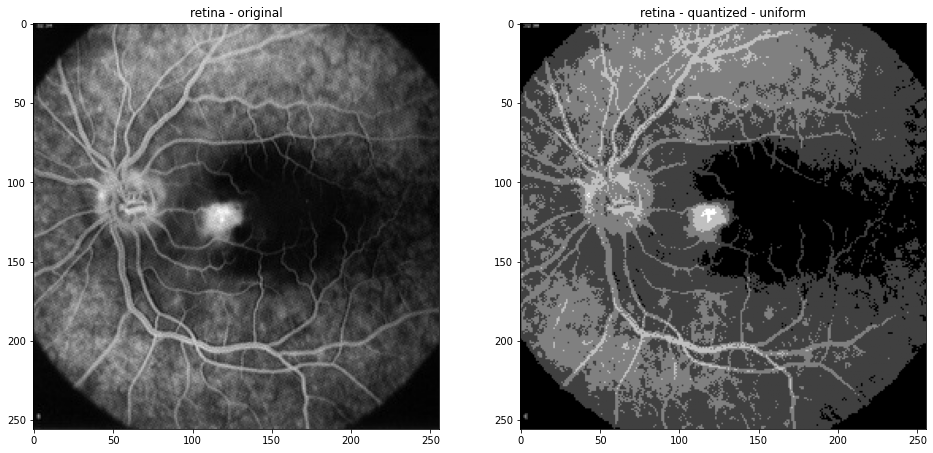

In [115]:
#@title Quantize uniform { run: "auto" }

image = "retina" #@param ["retina","bacteria","head","mnist"]
n = 5 #@param {type:"slider", min:1, max:10, step:1}

# Get image
im = get_y(get_image(image))
im_q = quant_uniform(im,n)

# Plot result
plot_compare(im,im_q,image,'quantized - uniform')

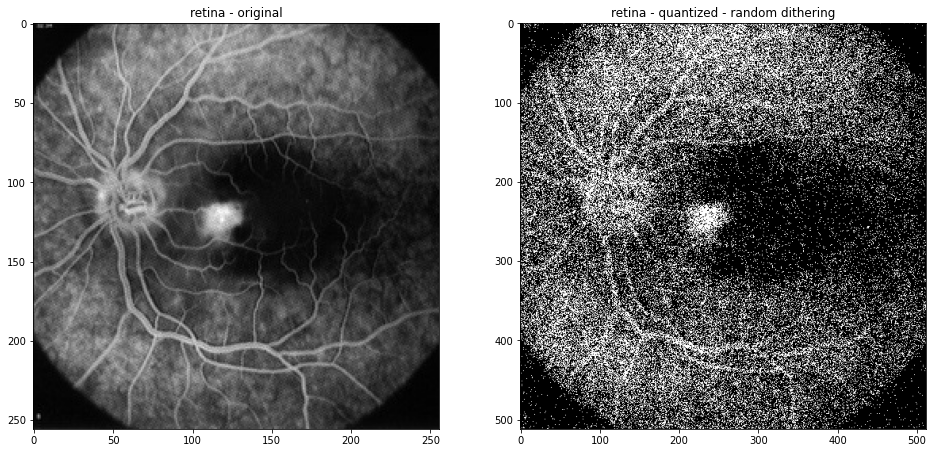

In [112]:
#@title Quantize random dithering { run: "auto" }

image = "retina" #@param ["retina","bacteria","head","mnist"]
n = 2 #@param {type:"slider", min:2, max:4, step:1}

# Get image
im = get_y(get_image(image))
im_q = quant_dither_random(im,n)

# Plot result
plot_compare(im,im_q,image,'quantized - random dithering')

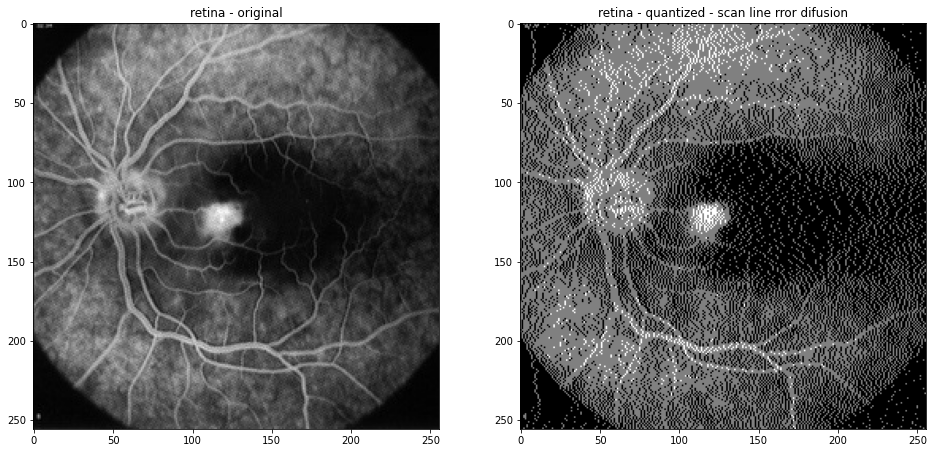

In [113]:
#@title Quantize error diffusion { run: "auto" }

image = "retina" #@param ["retina","bacteria","head","mnist"]
n = 2 #@param {type:"slider", min:2, max:4, step:1}

# Get image
im = get_y(get_image(image))
im_q = quant_error_diffusion(im,n)

# Plot result
plot_compare(im,im_q,image,'quantized - scan line rror difusion')

Text(0.5, 1.0, 'scanline error difusion')

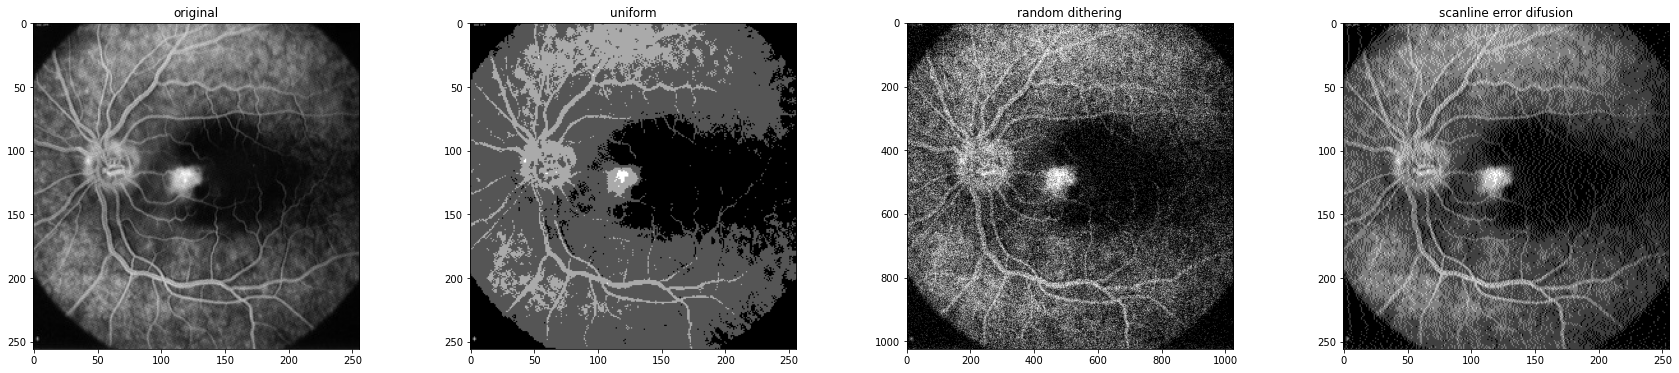

In [103]:
#@title Quantization comparison { run: "auto" }

image = "retina" #@param ["retina","bacteria","head","mnist"]
n = 4 #@param {type:"slider", min:2, max:4, step:1}

# Get image
im = get_y(get_image(image))

# Compute subsampling
im_uniform = quant_uniform(im,n)
im_dither = quant_dither_random(im,n)
im_errord = quant_error_diffusion(im,n)

# Plot result
fig, axs = plt.subplots(1,4)
fig.set_size_inches(30,6)

axs[0].imshow(im,cmap = 'gray')
axs[0].set_title('original')

axs[1].imshow(im_uniform,cmap = 'gray')
axs[1].set_title('uniform')

axs[2].imshow(im_dither,cmap = 'gray')
axs[2].set_title('random dithering')

axs[3].imshow(im_errord,cmap = 'gray')
axs[3].set_title('scanline error difusion')